# Import Dataset

In [1]:
from pandas import read_csv
series = read_csv('water.csv', header = 0, index_col = 0)

# Test Harness

## (i) Define validation dataset

Since the dataset is not current, we cannot easily collect updated data to validate the model. Hence, we will withhold the last 10 years of data from analysis and model selection. The final decade of data will be used to validate the final model.

In [2]:
split_point = len(series) - 10
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

Dataset 69, Validation 10


The specific contents of these files are:
* dataset.csv: Observations from 1885 to 1953 (69 observations)
* validation.csv: Observations from 1954 to 1963 (10 observations)

## (ii) Model Evaluation

Model evaluation will be performed on the data in dataset.csv. It involves 2 elements:

### 1) Performance measure

Performanace of predictions will be evaluated using the root mean squared error (RMSE). This will give more weight to predictions that are grossly wrong and will have the same units as the original data.

### 2) Test strategy 

Candidate models will be evaluated using walk-forward validation. This method works as follows:
* The first 50% of the dataset will be held back to train the model.
* The remaining 50% of the dataset will be iterated to test the model.
* For each step in the test dataset:
  * A model will be trained.
  * A one-step prediciton made, and the prediction stored for later evaluation.
  * The actual observation from the test dataset will be added to the training dataset for the next iteration.
* The predictions made during the enumeration of the test dataset will be evaluated and an RMSE score reported.

Given the small size of the data, we will allow a model to be re-trained given all available data prior to each prediction.

# Persistence

The first step before performing data analysis and modelling is to establish a baseline of performance. The baseline prediction for time series forecasting is called the naive forecast, or persistence.

In this method of forecasting, the observation from the previous step is used as the prediction for the observation at the next step.

In [3]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [4]:
# Load data
series = read_csv('dataset.csv', header = 0, index_col = 0)

In [5]:
# Prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

In [6]:
# Walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # Predict
    yhat = history[-1]
    predictions.append(yhat)
    # Observation
    obs = test[i]
    history.append(obs)
    print('>Predicted = %.3f, Expected = %.3f' % (yhat, obs))

>Predicted = 503.000, Expected = 503.000
>Predicted = 503.000, Expected = 503.000
>Predicted = 503.000, Expected = 515.000
>Predicted = 515.000, Expected = 522.000
>Predicted = 522.000, Expected = 492.000
>Predicted = 492.000, Expected = 503.000
>Predicted = 503.000, Expected = 503.000
>Predicted = 503.000, Expected = 450.000
>Predicted = 450.000, Expected = 432.000
>Predicted = 432.000, Expected = 432.000
>Predicted = 432.000, Expected = 458.000
>Predicted = 458.000, Expected = 462.000
>Predicted = 462.000, Expected = 503.000
>Predicted = 503.000, Expected = 488.000
>Predicted = 488.000, Expected = 466.000
>Predicted = 466.000, Expected = 492.000
>Predicted = 492.000, Expected = 503.000
>Predicted = 503.000, Expected = 515.000
>Predicted = 515.000, Expected = 500.000
>Predicted = 500.000, Expected = 522.000
>Predicted = 522.000, Expected = 575.000
>Predicted = 575.000, Expected = 583.000
>Predicted = 583.000, Expected = 587.000
>Predicted = 587.000, Expected = 628.000
>Predicted = 628

In [7]:
# Report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

RMSE: 21.975


We observe that the persistence model achieved an RMSE of 21.975. This means that on average, the model was wrong by about 22 litres per capita per day for each prediction made.

# Data analysis

## (1) Summary statistics 

In [8]:
print(series.describe())

            Water
count   69.000000
mean   500.478261
std     73.901685
min    344.000000
25%    458.000000
50%    492.000000
75%    538.000000
max    662.000000


* The mean is about 500, which we might consider our level in the series.
* Standard deviation and percentiles suggest a reasonably tight spread around the mean.

## (2) Line plot

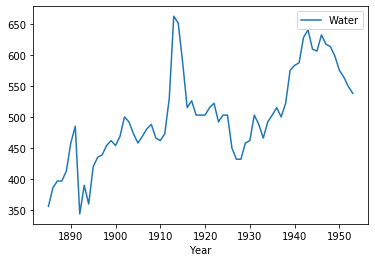

In [9]:
from matplotlib import pyplot as plt
series.plot()
plt.show()

* There is an overall increasing trend in water usage over time.
* There do not appear to be any obvious outliers, although there are some large fluctuations. 
* There is a downward trend for the last few years of the series.

## (3) Density plot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002C4DBC7E888>]],
      dtype=object)

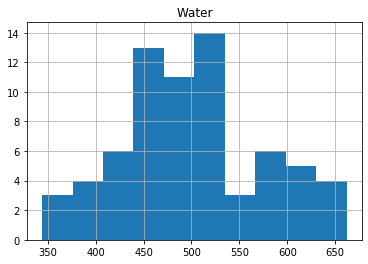

In [10]:
series.hist()

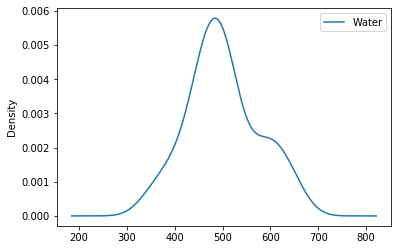

In [11]:
series.plot(kind = 'kde')

* The distribution is not Gaussian, but is pretty close.
* The distribution has a long right tail and may suggest an exponential distribution or a double Gaussian.

# ARIMA models

Autoregressive Integrated Moving Average (ARIMA) models are used for this problem. We will approach modelling by both manual and automatic configuration of the ARIMA model. This section is broken down into 3 steps:

## (1) Manually configured ARIMA 

Analysis of time series data assumes that we are working with a stationary time series. The time series is likely non-stationary. We can make it stationary by first differencing the series and using a statistical test to confirm that the result is stationary.

In [12]:
import pandas
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot

In [13]:
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return pandas.Series(diff)

In [14]:
stationary = difference(X)
stationary.index = series.index[1:]
stationary = stationary.astype('float32')

In [15]:
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.126719
p-value: 0.000000
Critical Values:
	1%: -3.534
	5%: -2.906
	10%: -2.591


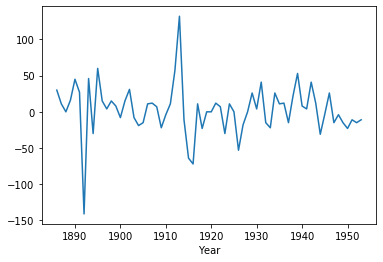

In [16]:
stationary.plot()
pyplot.show()

The next step is to select lag values for the Autoregressive (AR) and Moving Average (MA) parameters, p and q respectively.

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

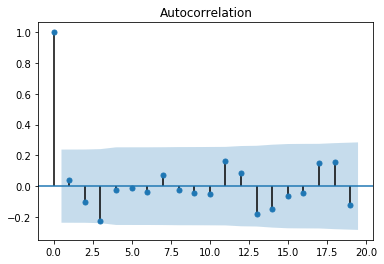

In [18]:
pyplot.figure()
plot_acf(stationary, ax = pyplot.gca())
pyplot.show()

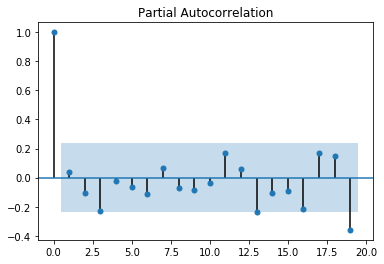

In [19]:
pyplot.figure()
plot_pacf(stationary, ax = pyplot.gca())
pyplot.show()

* PACF of the differenced series displays a sharp cut-off and the lag-1 autocorrelation is positive but insignificant. Hence, we will not have an AR term.
* ACF of the differenced series also shows a sharp cut-off and the lag-1 autocorrelation is not negative. Hence, we will not add an MA term.
* Hence, ARIMA(0,1,0) is a good starting point.

In [20]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt

In [21]:
series = read_csv('dataset.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

In [22]:
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # Predict
    model = ARIMA(history, order = (0,1,0))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    # Observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=507.455, Expected=503.000
>Predicted=507.324, Expected=503.000
>Predicted=507.200, Expected=515.000
>Predicted=519.417, Expected=522.000
>Predicted=526.486, Expected=492.000
>Predicted=495.579, Expected=503.000
>Predicted=506.769, Expected=503.000
>Predicted=506.675, Expected=450.000
>Predicted=452.293, Expected=432.000
>Predicted=433.810, Expected=432.000
>Predicted=433.767, Expected=458.000
>Predicted=460.318, Expected=462.000
>Predicted=464.356, Expected=503.000
>Predicted=506.196, Expected=488.000
>Predicted=490.809, Expected=466.000
>Predicted=468.292, Expected=492.000
>Predicted=494.776, Expected=503.000
>Predicted=505.940, Expected=515.000
>Predicted=518.118, Expected=500.000
>Predicted=502.769, Expected=522.000
>Predicted=525.132, Expected=575.000
>Predicted=579.056, Expected=583.000
>Predicted=587.127, Expected=587.000
>Predicted=591.125, Expected=628.000
>Predicted=632.772, Expected=640.000
>Predicted=644.897, Expected=609.000
>Predicted=613.288, Expected=606.000
>

## (2) Grid Search ARIMA Hyperparameters

In [23]:
import warnings
def evaluate_arima_model(X, arima_order):
    # Prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # Make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order = arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # Calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse <best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [24]:
series = read_csv('dataset.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
p_values = range(0,5)
d_values = range(0,3)
q_values = range(0,5)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=76.755
ARIMA(0, 0, 1) RMSE=47.346
ARIMA(0, 0, 2) RMSE=36.048
ARIMA(0, 0, 3) RMSE=32.587
ARIMA(0, 1, 0) RMSE=22.311
ARIMA(0, 1, 1) RMSE=22.258
ARIMA(0, 1, 2) RMSE=28.430
ARIMA(0, 1, 3) RMSE=30.054
ARIMA(0, 1, 4) RMSE=30.029
ARIMA(0, 2, 0) RMSE=29.335
ARIMA(0, 2, 1) RMSE=23.072
ARIMA(0, 2, 2) RMSE=22.954
ARIMA(0, 2, 3) RMSE=23.374
ARIMA(0, 2, 4) RMSE=29.178
ARIMA(1, 0, 0) RMSE=23.958
ARIMA(1, 0, 1) RMSE=23.998
ARIMA(1, 0, 2) RMSE=25.412
ARIMA(1, 0, 3) RMSE=30.499
ARIMA(1, 1, 0) RMSE=22.270
ARIMA(1, 2, 0) RMSE=27.786
ARIMA(1, 2, 1) RMSE=22.979
ARIMA(2, 0, 0) RMSE=24.131
ARIMA(2, 0, 1) RMSE=24.140
ARIMA(2, 1, 0) RMSE=22.084
ARIMA(2, 2, 0) RMSE=25.616
ARIMA(3, 0, 0) RMSE=24.183
ARIMA(3, 0, 1) RMSE=25.202
ARIMA(3, 1, 0) RMSE=25.060
ARIMA(3, 1, 1) RMSE=32.092
ARIMA(3, 2, 0) RMSE=26.126
ARIMA(3, 2, 1) RMSE=25.594
ARIMA(4, 0, 0) RMSE=25.113
ARIMA(4, 0, 1) RMSE=25.169
ARIMA(4, 1, 0) RMSE=26.213
ARIMA(4, 1, 1) RMSE=31.097
ARIMA(4, 1, 2) RMSE=32.340
ARIMA(4, 2, 0) RMSE=27.798
A

We will select ARIMA(2,1,0) moving forward.

## (3) Review Residual Errors

Ideally, the distribution of residual errors should be Gaussian with zero mean.

In [25]:
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # Predict
    model = ARIMA(history, order = (2,1,0))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    # Observation
    obs = test[i]
    history.append(obs)

In [26]:
from pandas import DataFrame
residuals = [test[i] - predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())

               0
count  35.000000
mean   -2.649321
std    22.244594
min   -55.933520
25%   -19.569783
50%    -5.046834
75%     7.835831
max    47.976412


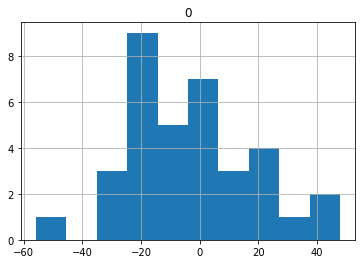

In [27]:
pyplot.figure()
residuals.hist(ax = pyplot.gca())
pyplot.show()

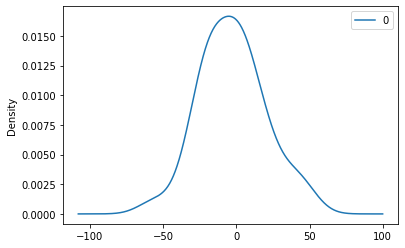

In [28]:
pyplot.figure()
residuals.plot(kind = 'kde', ax = pyplot.gca())
pyplot.show()

Perform bias-correction by adding the mean residual error of -2.649321 to each forecast made.

In [29]:
history = [x for x in train]
predictions = list()
bias = -2.649321
for i in range(len(test)):
    # Predict
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit()
    yhat = bias + float(model_fit.forecast()[0])
    predictions.append(yhat)
    # Observation
    obs = test[i]
    history.append(obs)

In [30]:
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

RMSE: 21.925


In [31]:
residuals = [test[i] - predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())

                  0
count  3.500000e+01
mean  -2.623915e-07
std    2.224459e+01
min   -5.328420e+01
25%   -1.692046e+01
50%   -2.397513e+00
75%    1.048515e+01
max    5.062573e+01


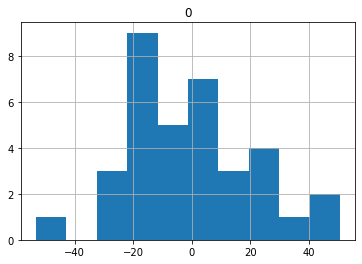

In [32]:
pyplot.figure()
residuals.hist(ax = pyplot.gca())
pyplot.show()

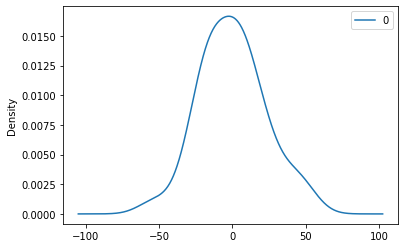

In [33]:
pyplot.figure()
residuals.plot(kind = 'kde', ax = pyplot.gca())
pyplot.show()

# Model Validation

## (1) Finalize Model

Fit ARIMA(2,1,0) model on the entire dataset

In [34]:
model = ARIMA(X, order = (2,1,0))
model_fit = model.fit()
bias = -2.649321

## (2) Make Prediction

Make a prediction for the next time step and print the prediction.

In [35]:
yhat = bias + float(model_fit.forecast()[0])
print('Predicted: %.3f' % yhat)

Predicted: 539.269


## (3) Validate Model

Make forecasts using the rolling-forecast manner, updating the transform and model for each time step.

In [36]:
y = validation.values.astype('float32')
predictions = list()
yhat = bias + float(model_fit.forecast()[0])
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0]))
for i in range(1, len(y)):
    # Predict
    model = ARIMA(history, order = (2,1,0))
    model_fit = model.fit()
    yhat = bias + float(model_fit.forecast()[0])
    predictions.append(yhat)
    # Observation
    obs = y[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

>Predicted=539.269, Expected=568.000
>Predicted=570.988, Expected=575.000
>Predicted=572.603, Expected=579.000
>Predicted=579.063, Expected=587.000
>Predicted=587.624, Expected=602.000
>Predicted=602.646, Expected=594.000
>Predicted=592.797, Expected=587.000
>Predicted=588.229, Expected=587.000
>Predicted=588.347, Expected=625.000
>Predicted=627.565, Expected=613.000


**Report Performance**

In [37]:
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)

RMSE: 16.786


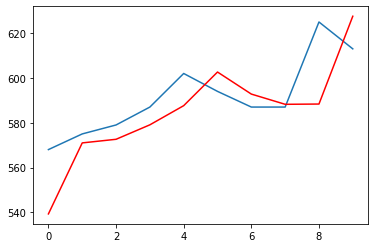

In [38]:
pyplot.plot(y)
pyplot.plot(predictions, color = 'red')
pyplot.show()